In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
Root = "/content/drive/MyDrive/brain_tumor_dataset"
os.chdir(Root)

In [5]:
#Import the necessary libraries first

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2

In [6]:
data = '/content/drive/MyDrive/brain_tumor_dataset/'
No_brain_tumor = '/content/drive/MyDrive/brain_tumor_dataset/no/'
Yes_brain_tumor = '/content/drive/MyDrive/brain_tumor_dataset/yes/'

In [7]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [8]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/drive/MyDrive/brain_tumor_dataset/no/...,No
1,/content/drive/MyDrive/brain_tumor_dataset/no/...,No
2,/content/drive/MyDrive/brain_tumor_dataset/no/...,No
3,/content/drive/MyDrive/brain_tumor_dataset/no/...,No
4,/content/drive/MyDrive/brain_tumor_dataset/no/...,No


In [9]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


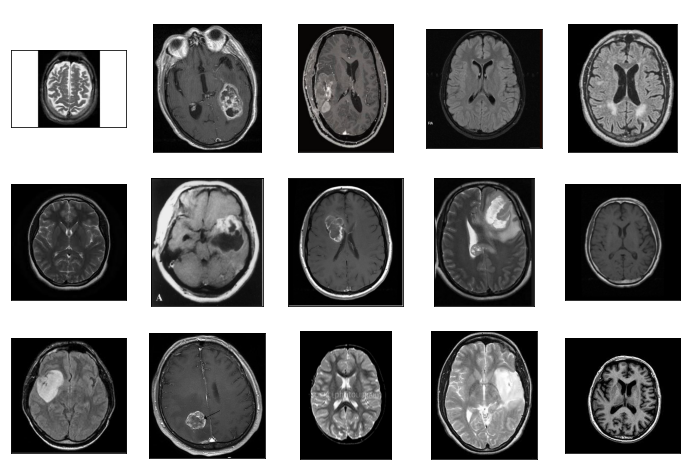

In [10]:
#visualize brain tumor images

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, random_state=0)
train_new, valid = train_test_split(train, train_size=0.75, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (151, 2)
test set shape: (51, 2)
validation set shape: (51, 2)


Let's start the modelling task
The ImageDataGenerator for keras is awesome.
It lets you augment your images in real-time while your model is still training! 
You can apply any random transformations on each training image as it is passed to the model. 
This will not only make your model robust but will also save up on the overhead memory!


We will apply the Image Data Generator on training with various parameters, but we won't apply 
the same parameters on testin. Why?
Because we want the test iamges as it is, we don't want biasedness,
also if we fit it we will be applying
the model only on these test images only, it can't predict new images if fed into model
Because new images will not be augmented this way

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation

In [13]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 151 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [14]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

Our base model is InceptionResNetV2

In [15]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable

In [16]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_detection_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/100
5/5 [==============================] - 29s 4s/step - loss: 0.8670 - accuracy: 0.4371 - val_loss: 0.8629 - val_accuracy: 0.4902
Epoch 2/100
5/5 [==============================] - 3s 754ms/step - loss: 0.8192 - accuracy: 0.4834 - val_loss: 0.7330 - val_accuracy: 0.5490
Epoch 3/100
5/5 [==============================] - 3s 601ms/step - loss: 0.7783 - accuracy: 0.5497 - val_loss: 0.7809 - val_accuracy: 0.5490
Epoch 4/100
5/5 [==============================] - 3s 606ms/step - loss: 0.8162 - accuracy: 0.5099 - val_loss: 0.7417 - val_accuracy: 0.5294
Epoch 5/100
5/5 [==============================] - 3s 625ms/step - loss: 0.7886 - accuracy: 0.5430 - val_loss: 0.7760 - val_accuracy: 0.5490
Epoch 6/100
5/5 [==============================] - 4s 941ms/step - loss: 0.8142 - accuracy: 0.5364 - val_loss: 0.7008 - val_accuracy: 0.5686
Epoch 7/100
5/5 [==============================] - 3s 608ms/step - loss: 0.7655 - accuracy: 0.5364 - val_loss: 0.7624 - val_accuracy: 0.5098
Epoch 8/100
5/5

In [17]:
model.save("/content/drive/MyDrive/Colab Notebooks/final model brain tumor detection/Tumor_detection_model.h5")

**Evaluating the model**

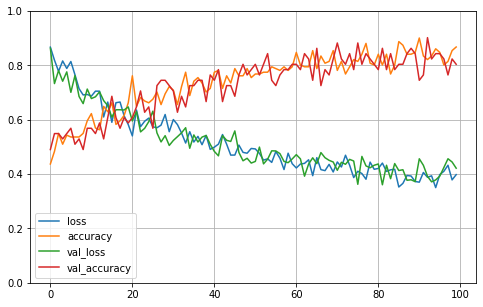

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [21]:
from PIL import Image
model_path = "Tumor_detection_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/brain_tumor_dataset/no/12 no.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred>=0.5:
  print("Yes Tumor Detected with a predicted value of:",pred)
else:
  print("NO Tumor Detected")

1/1 [==============================] - 1s 681ms/step
NO Tumor Detected


In [22]:
train_gen.class_indices

{'No': 0, 'Yes': 1}